In [2]:
import torch
print(torch.cuda.device_count())


import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time


import matplotlib.pyplot as plt


import numpy as np
from sklearn.decomposition import PCA


from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
#from your_model import ComplexFashionMNISTNet2  # Import your mode

1


# Data Preparation

In [3]:
#Data cleansing and transformation
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_transforms = transforms.Compose([
    transforms.ToTensor(), # integers ranging from 0 to 255 (for 8-bit images). ToTensor rescales these values to a floating-point range of [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,)) # commonly known as Normalization or Feature Scaling
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])
trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=20, shuffle=False, num_workers=4)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


# Exploratory Data Analysis (EDA)

In [8]:
classes = {0 : 'T-Shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
           4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag',
           9 : 'Ankle boot'}
classes

{0: 'T-Shirt/Top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
#classe
labels = trainset.targets.numpy()
# Calculate class distributions
class_distribution = {i: labels.tolist().count(i) for i in range(10)}
print("Class distributions:", class_distribution)
# we need a plot and a class name


Class distributions: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


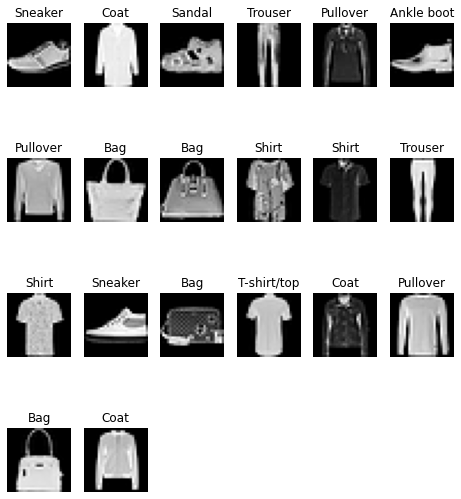

In [ ]:

# Assuming you have 'train_loader' containing your training DataLoader
# Define the classes for FashionMNIST
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display the images along with their labels
num_samples =20 # Number of samples to display
plt.figure(figsize=(8,12))

# Loop through the DataLoader to get sample images
for i, (images, labels) in enumerate(trainloader):
    if i >= num_samples // trainloader.batch_size:
        break
    for j in range(trainloader.batch_size):
        plt.subplot(5,6, i * trainloader.batch_size + j + 1)
        plt.imshow(images[j].numpy().squeeze(), cmap='gray')  # Convert tensor to numpy array and remove single-dimensional entries
        plt.title(class_labels[labels[j]])
        plt.axis('off')

#plt.tight_layout()
plt.show()


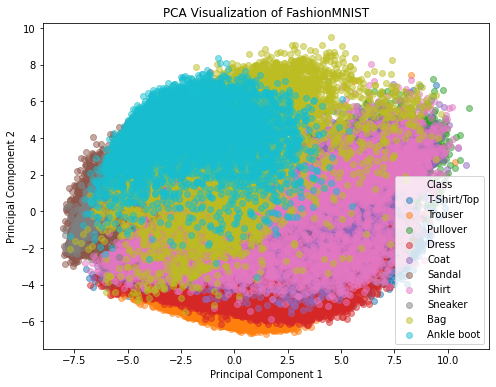

In [ ]:
# Flatten images for PCA
images = trainset.data.reshape(-1, 28 * 28).float() / 255 
labels = trainset.targets

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(images)

# Plot examples from classes using reduced dimensions
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.scatter(
        principal_components[labels == i, 0],
        principal_components[labels == i, 1],
        label=str(classes[i]),
        alpha=0.5,
    )
plt.title("PCA Visualization of FashionMNIST")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Class')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ComplexFashionMNISTNet(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet, self).__init__()
        #Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        #Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        #Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    

#Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
    return model,running_loss / len(train_loader)

#Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'batch_size': [16,32,64],
    'dropout_rate': [0.2, 0.4],
}

#Prepare FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



best_score = 10
best_params = {}

#Grid search for hyperparameters
for batch_size in param_grid['batch_size']:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    for lr in param_grid['learning_rate']:
        for dropout_rate in param_grid['dropout_rate']:
            params = {
                'dropout_rate': dropout_rate,
                'learning rate' : lr,
                'batch_size' : batch_size
            }

            #Initialize the model, optimizer, and loss function
            model = ComplexFashionMNISTNet(dropout_rate).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            
           
            
            #Train the model
            trained_model = train_model(model, trainloader, criterion, optimizer, epochs=5)
            

            #Evaluate the model on validation set (not included in this example)
            eval_model,loss = train_model(model, validationloader, criterion, optimizer, epochs=1)
            

            # Calculate a score based on model performance (e.g., accuracy)

            # Update best_params if the current model performs better
            # For demonstration purposes, assuming higher accuracy means better performance
            current_score = loss  # Replace this with your actual evaluation metric
            if current_score < best_score:
                best_score = current_score
                print('best_score_changed ',best_score)
                best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Epoch 1, Loss: 1.426
Epoch 2, Loss: 0.470
Epoch 3, Loss: 0.340
Epoch 4, Loss: 0.284
Epoch 5, Loss: 0.250
Epoch 1, Loss: 0.272
best_score_changed  0.2719451690328618
Epoch 1, Loss: 1.277
Epoch 2, Loss: 0.467
Epoch 3, Loss: 0.353
Epoch 4, Loss: 0.296
Epoch 5, Loss: 0.263
Epoch 1, Loss: 0.282
Epoch 1, Loss: 2.315
Epoch 2, Loss: 2.317
Epoch 3, Loss: 2.316
Epoch 4, Loss: 2.316
Epoch 5, Loss: 2.317
Epoch 1, Loss: 2.315
Epoch 1, Loss: 2.171
Epoch 2, Loss: 2.317
Epoch 3, Loss: 2.316
Epoch 4, Loss: 2.317
Epoch 5, Loss: 2.316
Epoch 1, Loss: 2.316
Epoch 1, Loss: 1.621
Epoch 2, Loss: 0.578
Epoch 3, Loss: 0.394
Epoch 4, Loss: 0.317
Epoch 5, Loss: 0.283
Epoch 1, Loss: 0.285
Epoch 1, Loss: 1.597
Epoch 2, Loss: 0.581
Epoch 3, Loss: 0.416
Epoch 4, Loss: 0.341
Epoch 5, Loss: 0.302
Epoch 1, Loss: 0.303
Epoch 1, Loss: 1.686
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 1, Loss: nan
Epoch 1, Loss: 1.978
Epoch 2, Loss: 2.310
Epoch 3, Loss: 2.309
Epoch 4, Loss: 2.310
Epoch

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)
# Define complex network for FashionMNIST

class ComplexFashionMNISTNet(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing()
])

#enable GPU
model = ComplexFashionMNISTNet(dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start_time = time.time()
#train

epoch_losses = []
old_epoch = 10
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Calculate and store the average loss for this epoch
        avg_loss = running_loss / len(trainloader)
    if (avg_loss > old_epoch):
        break
    epoch_losses.append(avg_loss)
    old_epoch = epoch_losses[-1]
    print(f'Epoch {epoch+1},  Loss: {avg_loss:.3f}')

end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time

print('Finished Training')
print(f'Total Training Time: {total_training_time:.2f} seconds')

Epoch 1,  Loss: 1.184
Epoch 2,  Loss: 0.452
Epoch 3,  Loss: 0.342
Epoch 4,  Loss: 0.293
Epoch 5,  Loss: 0.259
Epoch 6,  Loss: 0.238
Epoch 7,  Loss: 0.216
Epoch 8,  Loss: 0.194
Epoch 9,  Loss: 0.181
Epoch 10,  Loss: 0.166
Epoch 11,  Loss: 0.156
Epoch 12,  Loss: 0.142
Epoch 13,  Loss: 0.133
Epoch 14,  Loss: 0.124
Epoch 15,  Loss: 0.115
Epoch 16,  Loss: 0.104
Epoch 17,  Loss: 0.096
Epoch 18,  Loss: 0.091
Epoch 19,  Loss: 0.087
Epoch 20,  Loss: 0.079
Finished Training
Total Training Time: 559.00 seconds


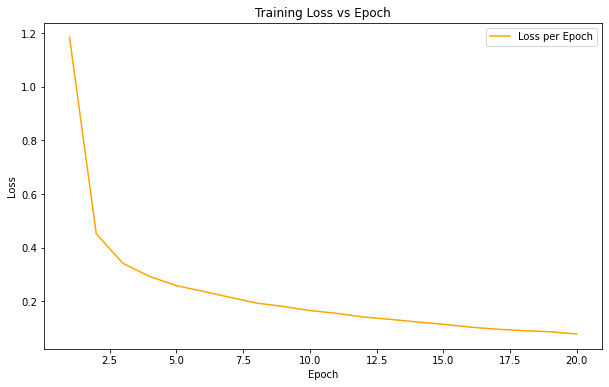

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), epoch_losses, label='Loss per Epoch',color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

# Training Metrics:

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.980     0.923     0.951      4769
     Trouser      0.999     0.996     0.998      4795
    Pullover      0.987     0.937     0.961      4793
       Dress      0.982     0.981     0.982      4825
        Coat      0.945     0.977     0.961      4787
      Sandal      0.981     1.000     0.990      4808
       Shirt      0.903     0.969     0.935      4839
     Sneaker      0.974     0.996     0.984      4782
         Bag      0.994     1.000     0.997      4817
  Ankle boot      0.999     0.957     0.977      4785

    accuracy                          0.974     48000
   macro avg      0.974     0.974     0.974     48000
weighted avg      0.974     0.974     0.974     48000



# Validition Metrics:


In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.900     0.805     0.850      1231
     Trouser      0.991     0.983     0.987      1205
    Pullover      0.901     0.838     0.868      1207
       Dress      0.916     0.922     0.919      1175
        Coat      0.863     0.886     0.875      1213
      Sandal      0.954     0.992     0.973      1192
       Shirt      0.713     0.807     0.757      1161
     Sneaker      0.946     0.972     0.959      1218
         Bag      0.966     0.993     0.980      1183
  Ankle boot      0.992     0.925     0.957      1215

    accuracy                          0.912     12000
   macro avg      0.914     0.912     0.912     12000
weighted avg      0.915     0.912     0.913     12000



# Test Metrics:

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.883     0.804     0.841      1000
     Trouser      0.993     0.982     0.987      1000
    Pullover      0.904     0.827     0.864      1000
       Dress      0.924     0.915     0.920      1000
        Coat      0.850     0.887     0.868      1000
      Sandal      0.958     0.992     0.974      1000
       Shirt      0.718     0.799     0.756      1000
     Sneaker      0.941     0.973     0.957      1000
         Bag      0.958     0.989     0.973      1000
  Ankle boot      0.988     0.926     0.956      1000

    accuracy                          0.909     10000
   macro avg      0.912     0.909     0.910     10000
weighted avg      0.912     0.909     0.910     10000



# 5x-Conv 5x-fc (CNN-2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet2, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    
# Define your model
class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self, dropout_rate):
        super(ComplexFashionMNISTNet2, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}')
    return model,running_loss / len(train_loader)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'batch_size': [16,32,64],
    'dropout_rate': [0.2, 0.4],
}

# Prepare FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

best_score = 10
best_params = {}

# Grid search for hyperparameters
for batch_size in param_grid['batch_size']:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    for lr in param_grid['learning_rate']:
        for dropout_rate in param_grid['dropout_rate']:
            params = {
                'dropout_rate': dropout_rate,
                'learning rate' : lr,
                'batch_size' : batch_size
            }

            # Initialize the model, optimizer, and loss function
            model = ComplexFashionMNISTNet2(dropout_rate).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            
           
            
            # Train the model
            trained_model = train_model(model, trainloader, criterion, optimizer, epochs=5)
            

            # Evaluate the model on validation set (not included in this example)
            eval_model,loss = train_model(model, validationloader, criterion, optimizer, epochs=1)
            

            # Calculate a score based on model performance (e.g., accuracy)

            # Update best_params if the current model performs better
            # For demonstration purposes, assuming higher accuracy means better performance
            current_score = loss  # Replace this with your actual evaluation metric
            if current_score < best_score:
                best_score = current_score
                print('best_score_changed ',best_score)
                best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Epoch 1, Loss: 2.260
Epoch 2, Loss: 0.759
Epoch 3, Loss: 0.408
Epoch 4, Loss: 0.327
Epoch 5, Loss: 0.287
Epoch 1, Loss: 0.293
best_score_changed  0.29291620443637173
Epoch 1, Loss: 2.300
Epoch 2, Loss: 0.926
Epoch 3, Loss: 0.434
Epoch 4, Loss: 0.340
Epoch 5, Loss: 0.294
Epoch 1, Loss: 0.306
Epoch 1, Loss: 2.317
Epoch 2, Loss: 2.317
Epoch 3, Loss: 2.316
Epoch 4, Loss: 2.316
Epoch 5, Loss: 2.317
Epoch 1, Loss: 2.316
Epoch 1, Loss: 2.317
Epoch 2, Loss: 2.315
Epoch 3, Loss: 2.317
Epoch 4, Loss: 2.317
Epoch 5, Loss: 2.317
Epoch 1, Loss: 2.315
Epoch 1, Loss: 2.304
Epoch 2, Loss: 1.622
Epoch 3, Loss: 0.563
Epoch 4, Loss: 0.380
Epoch 5, Loss: 0.310
Epoch 1, Loss: 0.312
Epoch 1, Loss: 2.303
Epoch 2, Loss: 2.200
Epoch 3, Loss: 0.858
Epoch 4, Loss: 0.480
Epoch 5, Loss: 0.371
Epoch 1, Loss: 0.342
Epoch 1, Loss: 2.310
Epoch 2, Loss: 2.309
Epoch 3, Loss: 2.310
Epoch 4, Loss: 2.309
Epoch 5, Loss: 2.310
Epoch 1, Loss: 2.310
Epoch 1, Loss: 2.310
Epoch 2, Loss: 2.310
Epoch 3, Loss: 2.309
Epoch 4, Loss: 

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)
# Define complex network for FashionMNIST
class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self):
        super(ComplexFashionMNISTNet2, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing()
])

#enable GPU
model = ComplexFashionMNISTNet2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

start_time = time.time()
#train

epoch_losses = []
old_epoch = 10
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Calculate and store the average loss for this epoch
        avg_loss = running_loss / len(trainloader)
    if (avg_loss > old_epoch):
        break
    epoch_losses.append(avg_loss)
    old_epoch = epoch_losses[-1]
    print(f'Epoch {epoch+1},  Loss: {avg_loss:.3f}')

end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time

print('Finished Training')
print(f'Total Training Time: {total_training_time:.2f} seconds')

Epoch 1,  Loss: 1.969
Epoch 2,  Loss: 0.546
Epoch 3,  Loss: 0.358
Epoch 4,  Loss: 0.296
Epoch 5,  Loss: 0.261
Epoch 6,  Loss: 0.237
Epoch 7,  Loss: 0.214
Epoch 8,  Loss: 0.198
Epoch 9,  Loss: 0.185
Epoch 10,  Loss: 0.169
Epoch 11,  Loss: 0.161
Epoch 12,  Loss: 0.152
Epoch 13,  Loss: 0.141
Epoch 14,  Loss: 0.127
Epoch 15,  Loss: 0.121
Epoch 16,  Loss: 0.113
Epoch 17,  Loss: 0.104
Finished Training
Total Training Time: 567.03 seconds


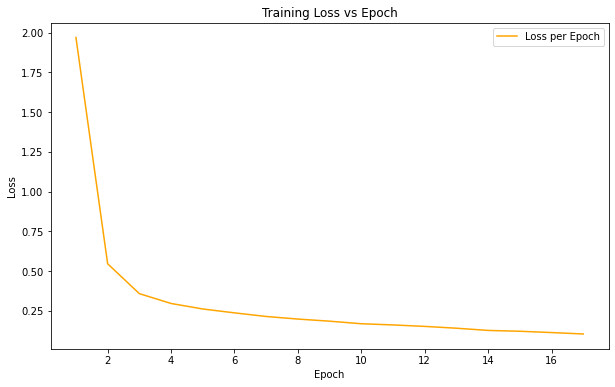

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), epoch_losses, label='Loss per Epoch',color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

# Train data set metrics

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.935     0.968     0.951      4769
     Trouser      0.999     0.999     0.999      4795
    Pullover      0.887     0.989     0.935      4793
       Dress      0.978     0.982     0.980      4825
        Coat      0.968     0.918     0.942      4787
      Sandal      0.997     0.999     0.998      4808
       Shirt      0.970     0.871     0.918      4839
     Sneaker      0.985     0.995     0.990      4782
         Bag      0.997     0.998     0.998      4817
  Ankle boot      0.997     0.985     0.991      4785

    accuracy                          0.970     48000
   macro avg      0.971     0.970     0.970     48000
weighted avg      0.971     0.970     0.970     48000



# Validation data set metrics

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.846     0.873     0.860      1231
     Trouser      0.986     0.979     0.983      1205
    Pullover      0.785     0.930     0.851      1207
       Dress      0.900     0.927     0.913      1175
        Coat      0.894     0.821     0.856      1213
      Sandal      0.970     0.986     0.978      1192
       Shirt      0.818     0.677     0.741      1161
     Sneaker      0.962     0.967     0.965      1218
         Bag      0.982     0.987     0.985      1183
  Ankle boot      0.980     0.963     0.971      1215

    accuracy                          0.912     12000
   macro avg      0.912     0.911     0.910     12000
weighted avg      0.912     0.912     0.911     12000



# Test data set metrics

In [ ]:
model.eval()

y_pred= []
y_true=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.837     0.880     0.858      1000
     Trouser      0.990     0.987     0.988      1000
    Pullover      0.776     0.939     0.850      1000
       Dress      0.927     0.904     0.915      1000
        Coat      0.883     0.833     0.857      1000
      Sandal      0.981     0.984     0.983      1000
       Shirt      0.824     0.678     0.744      1000
     Sneaker      0.952     0.973     0.962      1000
         Bag      0.982     0.975     0.978      1000
  Ankle boot      0.981     0.964     0.972      1000

    accuracy                          0.912     10000
   macro avg      0.913     0.912     0.911     10000
weighted avg      0.913     0.912     0.911     10000



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from your_model import ComplexFashionMNISTNet2  # Import your model

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.4, 0.6],
    # Other hyperparameters
}

# Initialize the model
model = ComplexFashionMNISTNet2()

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

# Train the model with different combinations of hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to train the final model
final_model = ComplexFashionMNISTNet2(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
test_accuracy = accuracy_score(y_test, final_model.predict(X_test))
